# nvImageCodecs with cuPy

In [1]:
import os
import cv2
import cupy as cp
from matplotlib import pyplot as plt
#os.chdir("c:\\Users\\smatysik\\projects\\nvimagecodecs\\build\\bin\\python")
os.chdir("/mnt/c/Users/smatysik/projects/nvimagecodecs/build/bin/python")
resources_dir = "../../../resources"
import nvimgcodecs


Load 4k, jpeg2000 image with nvImageCodecs

In [2]:
nv_img4k = nvimgcodecs.imread("{}/base/4k_lossless.jp2".format(resources_dir))
print(nv_img4k.__cuda_array_interface__)

{'shape': (3, 2160, 3840), 'strides': (8847360, 4096, 1), 'typestr': '=B', 'data': (47292874752, False), 'version': 2}


Pass nvImageCodecs Image to cupy

In [3]:
%%time
cp_img4k = cp.asarray(nv_img4k)
print(cp_img4k.__cuda_array_interface__)

{'shape': (3, 2160, 3840), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': (8847360, 4096, 1), 'data': (47292874752, False)}
CPU times: user 48.2 ms, sys: 7.67 ms, total: 55.9 ms
Wall time: 59.2 ms


Convert CHW(c-style) = Planar -> HWC (c-style) = Interleave

In [4]:
cp_img4k = cp.moveaxis(cp_img4k, (0, 1, 2), (2, 0, 1))
print(cp_img4k.__cuda_array_interface__)
#Uncoment for packing
# In Fortran the most rapidly changing index comes first
#cp_img4k = cp.asfortranarray(cp_img4k)
# print(cp_img4k.__cuda_array_interface__)
#cp_img4k = cp.ascontiguousarray(cp_img4k)
# print(cp_img4k.__cuda_array_interface__)


{'shape': (2160, 3840, 3), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': (4096, 1, 8847360), 'data': (47292874752, False)}


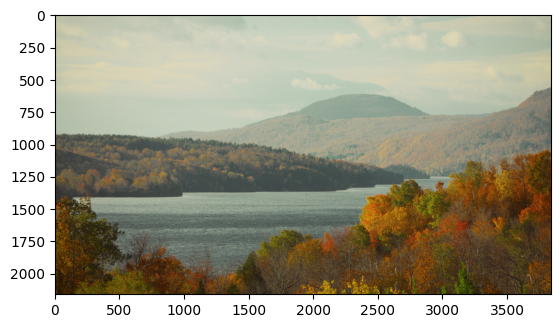

In [5]:
np_img4k = cp.asnumpy(cp_img4k)
plt.imshow(np_img4k)


Lets do some opration on image in GPU using cupyx.scipy

In [6]:
import cupyx.scipy.ndimage

In [7]:
cp_img_4k_rotated = cupyx.scipy.ndimage.rotate(cp_img4k, 90)
cp_img_4k_gaussian = cupyx.scipy.ndimage.gaussian_filter(cp_img4k, sigma = 15)
cp_img_4k_laplace = cupyx.scipy.ndimage.laplace(cp_img4k)

print(cp_img_4k_rotated.__cuda_array_interface__)

{'shape': (3840, 2160, 3), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': None, 'data': (47370469376, False)}


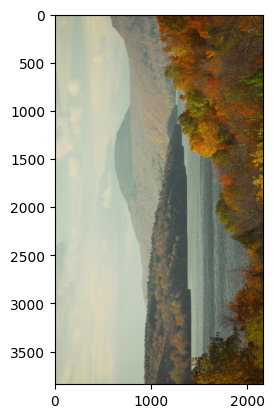

In [8]:
np_img_4k = cp.asnumpy(cp_img_4k_rotated)
plt.imshow(np_img_4k)

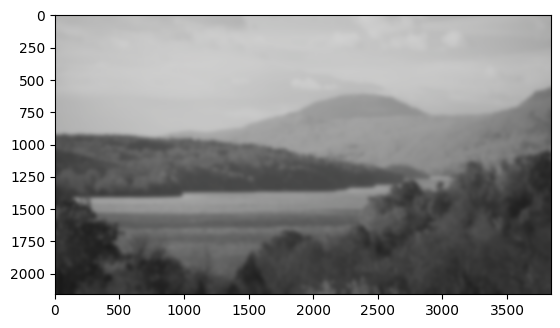

In [9]:
np_img_4k = cp.asnumpy(cp_img_4k_gaussian)
plt.imshow(np_img_4k)


Save as JPEG2000

nvJpeg2000 now supports only Planar RGB and cupy ndarray is in interleaved RGB format so we need to convert it before providing buffer to nvJpeg2000. In future nvJpeg2000 should probably support I_RGB.

In [10]:
# HWC (C-style = row-major) = interleaved -> CHW (C-style) = planar
print(cp_img_4k_rotated.__cuda_array_interface__)

cp_img_4k_rotated_planar = cp.moveaxis(cp_img_4k_rotated, (0, 1, 2), (1, 0, 2))
print(cp_img_4k_rotated_planar.__cuda_array_interface__)

cp_img_4k_rotated_planar = cp.asfortranarray(cp_img_4k_rotated_planar)
print(cp_img_4k_rotated_planar.__cuda_array_interface__)


cp_img_4k_rotated_planar = cp.moveaxis(cp_img_4k_rotated_planar, (0, 1, 2), (2, 1, 0))
print(cp_img_4k_rotated_planar.__cuda_array_interface__)


{'shape': (3840, 2160, 3), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': None, 'data': (47370469376, False)}
{'shape': (2160, 3840, 3), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': (3, 6480, 1), 'data': (47370469376, False)}
{'shape': (2160, 3840, 3), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': (1, 2160, 8294400), 'data': (47345303552, False)}
{'shape': (3, 3840, 2160), 'typestr': '|u1', 'descr': [('', '|u1')], 'stream': 1, 'version': 3, 'strides': None, 'data': (47345303552, False)}


In [11]:
%%time
nv_rotated_img = nvimgcodecs.asimage(cp_img_4k_rotated_planar)


CPU times: user 68 µs, sys: 49 µs, total: 117 µs
Wall time: 120 µs


In [ ]:
%%time
nvimgcodecs.imwrite("rotated.j2k", nv_rotated_img)


: 

: 

Load with OpenCv to verify

In [ ]:
image = cv2.imread("rotated.j2k")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

Save cupy image to jpg with nvImageCodecs

In [ ]:
%%time
nvimgcodecs.imwrite("rotated.jpg", nv_rotated_img)


In [ ]:
image = cv2.imread("rotated.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)